### Key Findings Summary

**1. Alpha (Excess Returns)**
- Average alpha across stocks: Shows whether stocks outperform/underperform after controlling for market and ESG factors
- Interpretation: Positive alpha = stock-specific skill/mispricing; Negative alpha = underperformance
- Statistical significance varies by stock - check p-values

**2. Market Beta (Systematic Risk)**
- Measures sensitivity to overall market movements
- Beta > 1: More volatile than market (amplifies market swings)
- Beta < 1: Less volatile than market (defensive)
- Beta ≈ 1: Moves in line with market
- Most market betas should be highly significant (p < 0.01)

**3. ESG Beta (ESG Factor Exposure)**
- Measures sensitivity to ESG factor (long high-ESG, short low-ESG portfolio)
- Positive ESG beta: Stock moves with high-ESG stocks (ESG leaders)
- Negative ESG beta: Stock moves with low-ESG stocks (ESG laggards)
- Zero ESG beta: Stock returns independent of ESG characteristics
- Significance varies - ESG effects are often weaker than market effects

**4. Model Fit (R²)**
- Percentage of return variance explained by market + ESG factors
- Higher R² = better model fit, more predictable returns
- Typical range: 30-70% for individual stocks
- Low R² suggests other factors or idiosyncratic risk dominate

**5. Economic Interpretation**
- Two-factor model improves on single-factor CAPM by adding ESG dimension
- Allows decomposition: Total Return = Alpha + Market Risk Premium + ESG Risk Premium + Error
- Useful for portfolio construction, risk management, and ESG integration

**Next Steps:**
- Compare with single-factor CAPM to assess ESG factor value-added
- Test time-variation in factor loadings (rolling window analysis above)
- Expand to 3+ factors (size, value, momentum) for multi-factor model
- Use results for portfolio optimization or risk attribution

# Two-Factor OLS Regression: Market + ESG

## Overview

This notebook demonstrates **two-factor OLS regression** to estimate factor exposures (betas) and alpha for stock returns.

### Regression Model

$$
R_{i,t} - RF_t = \alpha_i + \beta_{market} \cdot (R_{market,t} - RF_t) + \beta_{ESG} \cdot ESG_{factor,t} + \varepsilon_{i,t}
$$

Where:
- **$R_{i,t}$**: Stock return at time $t$
- **$RF_t$**: Risk-free rate at time $t$ (3-month Treasury Bill)
- **$R_{market,t}$**: Market return (SPY) at time $t$
- **$ESG_{factor,t}$**: ESG factor return at time $t$ (long-short portfolio)
- **$\alpha_i$**: Jensen's alpha (excess return not explained by factors)
- **$\beta_{market}$**: Market beta (sensitivity to market movements)
- **$\beta_{ESG}$**: ESG beta (sensitivity to ESG factor)
- **$\varepsilon_{i,t}$**: Idiosyncratic return (error term)

### What We'll Cover

1. Load and prepare data (stock returns, market returns, ESG factors, risk-free rate)
2. Run full-sample regressions for single and multiple stocks
3. Estimate time-varying betas using rolling windows
4. Visualize factor exposures over time
5. Compare ESG sensitivity across stocks
6. Analyze statistical significance and model fit

## 1. Import Required Libraries

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import logging
import warnings
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Custom modules
from core.config import Config
from market import RiskFreeRateManager
from universe import SP500Universe

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Initialize Components

Set up configuration and data paths.

In [2]:
# Initialize configuration
config = Config("../config/settings.yaml")
data_root = Path(config.get("storage.local.root_path"))

# Initialize universe
universe = SP500Universe(data_root)

# Initialize RiskFreeRateManager with absolute path
rf_data_root = (Path.cwd().parent / data_root / "curated" / "references" / "risk_free_rate" / "freq=monthly").resolve()
rf_manager = RiskFreeRateManager(data_root=str(rf_data_root), default_rate="3month")

# Define analysis parameters
START_DATE = "2014-01-01"
END_DATE = "2024-12-31"
ROLLING_WINDOW = 36  # 36-month rolling window
MIN_OBS = 24  # Minimum observations for regression

# Test tickers
TICKERS = ["AAPL", "MSFT", "GOOGL", "TSLA", "JNJ", "PG"]

print(f"✓ Configuration loaded")
print(f"  Data root: {data_root}")
print(f"  RF data root: {rf_data_root}")
print(f"  Analysis period: {START_DATE} to {END_DATE}")
print(f"  Test tickers: {', '.join(TICKERS)}")

✓ Configuration loaded
  Data root: data
  RF data root: /Users/frank/Projects/QuantX/quantx-data-builder/data/curated/references/risk_free_rate/freq=monthly
  Analysis period: 2014-01-01 to 2024-12-31
  Test tickers: AAPL, MSFT, GOOGL, TSLA, JNJ, PG


## 3. Load Risk-Free Rate Data

Load 3-month Treasury Bill rates using **RiskFreeRateManager**.

**Important:** FRED data format is **annual percentage** (e.g., 5.25 = 5.25% per year)
- Conversion: `annual_pct / 100 / 12` → monthly decimal
- Example: 6.0% annual → 0.005 monthly (0.5% per month)

In [3]:
# Load risk-free rate using RiskFreeRateManager
rf_data = rf_manager.load_risk_free_rate(
    start_date=START_DATE,
    end_date=END_DATE,
    rate_type="3month",
    frequency="monthly"
)

# FRED data is annual percentage (e.g., 5.25 = 5.25% per year)
# Convert to monthly decimal: annual_pct / 100 / 12
rf_df = rf_data.copy()
rf_df["date"] = pd.to_datetime(rf_df["date"])
rf_df["RF"] = rf_df["rate"] / 100 / 12  # Annual % → monthly decimal

rf_df = rf_df[["date", "RF"]]

print(f"✓ Loaded {len(rf_df)} risk-free rate observations")
print(f"  Period: {rf_df['date'].min()} to {rf_df['date'].max()}")
print(f"  Mean RF: {rf_df['RF'].mean():.6f} (monthly decimal) = {rf_df['RF'].mean()*12*100:.2f}% annual")
print(f"  FRED format confirmed: Annual percentage converted to monthly decimal")

# Display sample
rf_df.head()

✓ Loaded 132 risk-free rate observations
  Period: 2014-01-31 00:00:00 to 2024-12-31 00:00:00
  Mean RF: 0.001399 (monthly decimal) = 1.68% annual
  FRED format confirmed: Annual percentage converted to monthly decimal


,date,RF
0,2014-01-31,0.0000
1,2014-02-28,0.0000
2,2014-03-31,0.0000
3,2014-04-30,0.0000
4,2014-05-31,0.0000


## 4. Load Market Returns (SPY)

Load SPY monthly prices and calculate market returns.

In [4]:
# Load SPY monthly prices
market_path = Path.cwd().parent / data_root / "curated" / "references" / "ticker=SPY" / "prices" / "freq=monthly"

all_data = []
for year_dir in sorted(market_path.glob("year=*")):
    parquet_file = year_dir / "part-000.parquet"
    if parquet_file.exists():
        df = pd.read_parquet(parquet_file)
        all_data.append(df)

spy_df = pd.concat(all_data, ignore_index=True)
spy_df["date"] = pd.to_datetime(spy_df["date"])
spy_df = spy_df.sort_values("date")

# Calculate returns
spy_df["market_return"] = spy_df["adj_close"].pct_change()

# Merge with RF to calculate excess returns (rf_df already in monthly decimal)
market_df = spy_df[["date", "market_return"]].dropna()
market_df = market_df.merge(rf_df[["date", "RF"]], on="date", how="inner")
market_df["market_excess"] = market_df["market_return"] - market_df["RF"]

print(f"✓ Loaded {len(market_df)} market excess returns")
print(f"  Period: {market_df['date'].min()} to {market_df['date'].max()}")
print(f"  Mean monthly return: {market_df['market_return'].mean()*100:.2f}%")
print(f"  Mean monthly excess: {market_df['market_excess'].mean()*100:.2f}%")
print(f"  Annualized excess: {market_df['market_excess'].mean()*12*100:.2f}%")

# Display sample
market_df.head()

✓ Loaded 93 market excess returns
  Period: 2014-02-28 00:00:00 to 2024-12-31 00:00:00
  Mean monthly return: 1.06%
  Mean monthly excess: 0.92%
  Annualized excess: 11.01%


,date,market_return,RF,market_excess
0,2014-02-28,0.0455,0.0000,0.0455
1,2014-03-31,0.0083,0.0000,0.0083
2,2014-04-30,0.0070,0.0000,0.0069
3,2014-06-30,0.0206,0.0000,0.0206
4,2014-07-31,-0.0134,0.0000,-0.0135


## 5. Load ESG Factor Returns

Load pre-computed ESG factor returns (long-short portfolios).

In [5]:
# Load ESG factors
factors_file = Path.cwd().parent / data_root / "results" / "esg_factors" / "esg_factors.parquet"
esg_df = pd.read_parquet(factors_file)
esg_df = esg_df.reset_index()
esg_df.columns = ["date"] + list(esg_df.columns[1:])
esg_df["date"] = pd.to_datetime(esg_df["date"])

print(f"✓ Loaded {len(esg_df)} ESG factor observations")
print(f"  Period: {esg_df['date'].min()} to {esg_df['date'].max()}")
print(f"  Available factors: {[c for c in esg_df.columns if c != 'date']}")

# Display statistics
factor_stats = esg_df.drop(columns=["date"]).describe()
print("\nFactor Statistics (monthly decimal returns):")
print(factor_stats)

# Display sample
esg_df.head()

✓ Loaded 77 ESG factor observations
  Period: 2016-02-29 00:00:00 to 2024-12-31 00:00:00
  Available factors: ['ESG_factor', 'E_factor', 'S_factor', 'G_factor', 'ESG_mom_factor']

Factor Statistics (monthly decimal returns):
       ESG_factor  E_factor  S_factor  G_factor  ESG_mom_factor
count     77.0000   77.0000   77.0000   77.0000         77.0000
mean      -0.0038   -0.0031   -0.0029    0.0010         -0.0010
std        0.0188    0.0168    0.0200    0.0158          0.0134
min       -0.0466   -0.0320   -0.0521   -0.0532         -0.0389
25%       -0.0160   -0.0140   -0.0144   -0.0067         -0.0084
50%       -0.0020   -0.0057   -0.0020    0.0012         -0.0018
75%        0.0095    0.0091    0.0100    0.0129          0.0056
max        0.0374    0.0552    0.0553    0.0357          0.0400

  Period: 2016-02-29 00:00:00 to 2024-12-31 00:00:00
  Available factors: ['ESG_factor', 'E_factor', 'S_factor', 'G_factor', 'ESG_mom_factor']

Factor Statistics (monthly decimal returns):
       ES

,date,ESG_factor,E_factor,S_factor,G_factor,ESG_mom_factor
0,2016-02-29,-0.0110,-0.0283,-0.0069,-0.0191,-0.0134
1,2016-03-31,-0.0081,-0.0070,-0.0085,0.0026,-0.0006
2,2016-05-31,-0.0138,-0.0150,-0.0144,-0.0013,-0.0034
3,2016-06-30,0.0138,0.0225,0.0130,0.0295,-0.0051
4,2016-08-31,-0.0196,-0.0077,-0.0138,-0.0050,-0.0104


## 6. Helper Function: Load Stock Returns

Create a reusable function to load stock excess returns.

In [6]:
def load_stock_excess_returns(ticker: str, start_date: str, end_date: str) -> Optional[pd.DataFrame]:
    """Load stock returns and calculate excess returns using RiskFreeRateManager"""
    try:
        # Load monthly prices with absolute path
        ticker_path = (Path.cwd().parent / data_root / "curated" / "tickers" / 
                      "exchange=us" / f"ticker={ticker}" / "prices" / "freq=monthly")
        
        if not ticker_path.exists():
            print(f"❌ No price data for {ticker}")
            return None
        
        # Load all years in range
        start_year = pd.to_datetime(start_date).year
        end_year = pd.to_datetime(end_date).year
        
        all_data = []
        for year in range(start_year, end_year + 1):
            year_dir = ticker_path / f"year={year}"
            parquet_file = year_dir / "part-000.parquet"
            if parquet_file.exists():
                df = pd.read_parquet(parquet_file)
                all_data.append(df)
        
        if not all_data:
            print(f"❌ No price data for {ticker} in {start_date} to {end_date}")
            return None
        
        # Combine and calculate returns
        df = pd.concat(all_data, ignore_index=True)
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date")
        df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
        df["stock_return"] = df["adj_close"].pct_change()
        
        # Use global rf_df which is already in monthly decimal format
        stock_df = df[["date", "stock_return"]].dropna()
        stock_df = stock_df.merge(rf_df[["date", "RF"]], on="date", how="inner")
        stock_df["stock_excess"] = stock_df["stock_return"] - stock_df["RF"]
        
        return stock_df[["date", "stock_excess", "stock_return"]]
    
    except Exception as e:
        print(f"❌ Error loading {ticker}: {e}")
        return None

print("✓ Helper function defined")

✓ Helper function defined


## 7. Run Single Stock Regression (AAPL)

Perform OLS regression for AAPL to estimate alpha, market beta, and ESG beta.

In [7]:
# Load AAPL returns
ticker = "AAPL"
stock_df = load_stock_excess_returns(ticker, START_DATE, END_DATE)

if stock_df is not None:
    # Merge with market and ESG factors
    regression_data = stock_df.merge(market_df[["date", "market_excess"]], on="date", how="inner")
    regression_data = regression_data.merge(esg_df[["date", "ESG_factor"]], on="date", how="inner")
    
    print(f"✓ Merged data for {ticker}: {len(regression_data)} observations")
    print(f"  Period: {regression_data['date'].min()} to {regression_data['date'].max()}")
    
    # Prepare regression
    y = regression_data["stock_excess"]
    X = regression_data[["market_excess", "ESG_factor"]]
    X = sm.add_constant(X)
    
    # Run OLS
    model = sm.OLS(y, X).fit()
    
    # Display results
    print("\n" + "="*80)
    print(f"TWO-FACTOR REGRESSION RESULTS: {ticker}")
    print("="*80)
    print(model.summary())
    
    # Extract key metrics
    alpha = model.params["const"] * 12  # Annualized
    beta_market = model.params["market_excess"]
    beta_esg = model.params["ESG_factor"]
    
    print("\n" + "="*80)
    print("KEY METRICS")
    print("="*80)
    print(f"Alpha (annualized):  {alpha:.4f}  ({alpha*100:.2f}% per year)")
    print(f"  t-statistic:       {model.tvalues['const']:.2f}")
    print(f"  p-value:           {model.pvalues['const']:.4f}  {'***' if model.pvalues['const'] < 0.01 else '**' if model.pvalues['const'] < 0.05 else '*' if model.pvalues['const'] < 0.10 else ''}")
    print()
    print(f"Market Beta:         {beta_market:.4f}")
    print(f"  t-statistic:       {model.tvalues['market_excess']:.2f}")
    print(f"  p-value:           {model.pvalues['market_excess']:.4f}  {'***' if model.pvalues['market_excess'] < 0.01 else '**' if model.pvalues['market_excess'] < 0.05 else '*' if model.pvalues['market_excess'] < 0.10 else ''}")
    print()
    print(f"ESG Beta:            {beta_esg:.4f}")
    print(f"  t-statistic:       {model.tvalues['ESG_factor']:.2f}")
    print(f"  p-value:           {model.pvalues['ESG_factor']:.4f}  {'***' if model.pvalues['ESG_factor'] < 0.01 else '**' if model.pvalues['ESG_factor'] < 0.05 else '*' if model.pvalues['ESG_factor'] < 0.10 else ''}")
    print()
    print(f"R²:                  {model.rsquared:.4f}  ({model.rsquared*100:.2f}%)")
    print(f"Adjusted R²:         {model.rsquared_adj:.4f}  ({model.rsquared_adj*100:.2f}%)")
    print(f"F-statistic:         {model.fvalue:.2f}  (p={model.f_pvalue:.4f})")
    print(f"Observations:        {int(model.nobs)}")
    print("\n*** p<0.01, ** p<0.05, * p<0.10")

✓ Merged data for AAPL: 77 observations
  Period: 2016-02-29 00:00:00 to 2024-12-31 00:00:00

TWO-FACTOR REGRESSION RESULTS: AAPL
                            OLS Regression Results                            
Dep. Variable:           stock_excess   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     25.98
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.83e-09
Time:                        00:41:08   Log-Likelihood:                 106.30
No. Observations:                  77   AIC:                            -206.6
Df Residuals:                      74   BIC:                            -199.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975

## 8. Rolling Window Regression

Estimate time-varying factor exposures using a rolling window.

In [8]:
# Rolling window regression for AAPL
def run_rolling_regression(data: pd.DataFrame, window: int) -> pd.DataFrame:
    """Run rolling window regressions"""
    results = []
    
    for i in range(window, len(data) + 1):
        window_data = data.iloc[i - window : i]
        end_date = window_data["date"].iloc[-1]
        
        # Prepare regression
        y = window_data["stock_excess"]
        X = window_data[["market_excess", "ESG_factor"]]
        X = sm.add_constant(X)
        
        try:
            model = sm.OLS(y, X).fit()
            
            results.append({
                "date": end_date,
                "alpha": model.params["const"] * 12,  # Annualized
                "beta_market": model.params["market_excess"],
                "beta_esg": model.params["ESG_factor"],
                "alpha_tstat": model.tvalues["const"],
                "beta_market_tstat": model.tvalues["market_excess"],
                "beta_esg_tstat": model.tvalues["ESG_factor"],
                "r_squared": model.rsquared,
                "observations": int(model.nobs),
            })
        except:
            continue
    
    return pd.DataFrame(results)

# Run rolling regression
rolling_results = run_rolling_regression(regression_data, ROLLING_WINDOW)

print(f"✓ Completed {len(rolling_results)} rolling window regressions")
print(f"  Window size: {ROLLING_WINDOW} months")
print(f"  Period: {rolling_results['date'].min()} to {rolling_results['date'].max()}")

# Display summary statistics
summary_stats = rolling_results[["alpha", "beta_market", "beta_esg", "r_squared"]].describe()
print("\nRolling Regression Summary:")
print(summary_stats)

rolling_results.tail(10)

✓ Completed 42 rolling window regressions
  Window size: 36 months
  Period: 2020-03-31 00:00:00 to 2024-12-31 00:00:00

Rolling Regression Summary:
        alpha  beta_market  beta_esg  r_squared
count 42.0000      42.0000   42.0000    42.0000
mean   0.2737       1.1612    0.0487     0.4642
std    0.0728       0.0968    0.2262     0.1054
min    0.0776       0.9650   -0.3177     0.2711
25%    0.2407       1.0953   -0.0925     0.3670
50%    0.2952       1.1757    0.0140     0.4814
75%    0.3209       1.2313    0.1939     0.5587
max    0.3926       1.3339    0.5553     0.6153


,date,alpha,beta_market,beta_esg,alpha_tstat,beta_market_tstat,beta_esg_tstat,r_squared,observations
32,2023-10-31,0.2834,1.1744,-0.0758,2.4122,6.1091,-0.1468,0.5780,36
33,2023-11-30,0.2627,1.1772,0.0492,2.2662,6.3259,0.0949,0.5920,36
34,2024-01-31,0.2226,1.1770,0.0780,1.8811,6.1874,0.1475,0.5797,36
35,2024-02-29,0.1886,1.1726,0.2013,1.5192,5.9596,0.3683,0.5566,36
36,2024-04-30,0.1631,1.2561,0.2608,1.3233,5.9858,0.4955,0.5556,36
37,2024-05-31,0.1790,1.2874,0.2308,1.4414,5.7530,0.4330,0.5316,36
38,2024-07-31,0.1509,1.2705,0.1717,1.2800,5.9950,0.3411,0.5547,36
39,2024-09-30,0.1306,1.2582,0.4110,1.1626,6.1778,0.8181,0.5532,36
40,2024-10-31,0.0776,1.1045,-0.0353,0.7491,5.5358,-0.0708,0.5428,36
41,2024-12-31,0.1357,1.0232,-0.0428,1.3109,5.0717,-0.0857,0.5026,36


## 9. Visualize Time-Varying Factor Exposures

Plot rolling alpha and betas to see how factor exposures evolve over time.

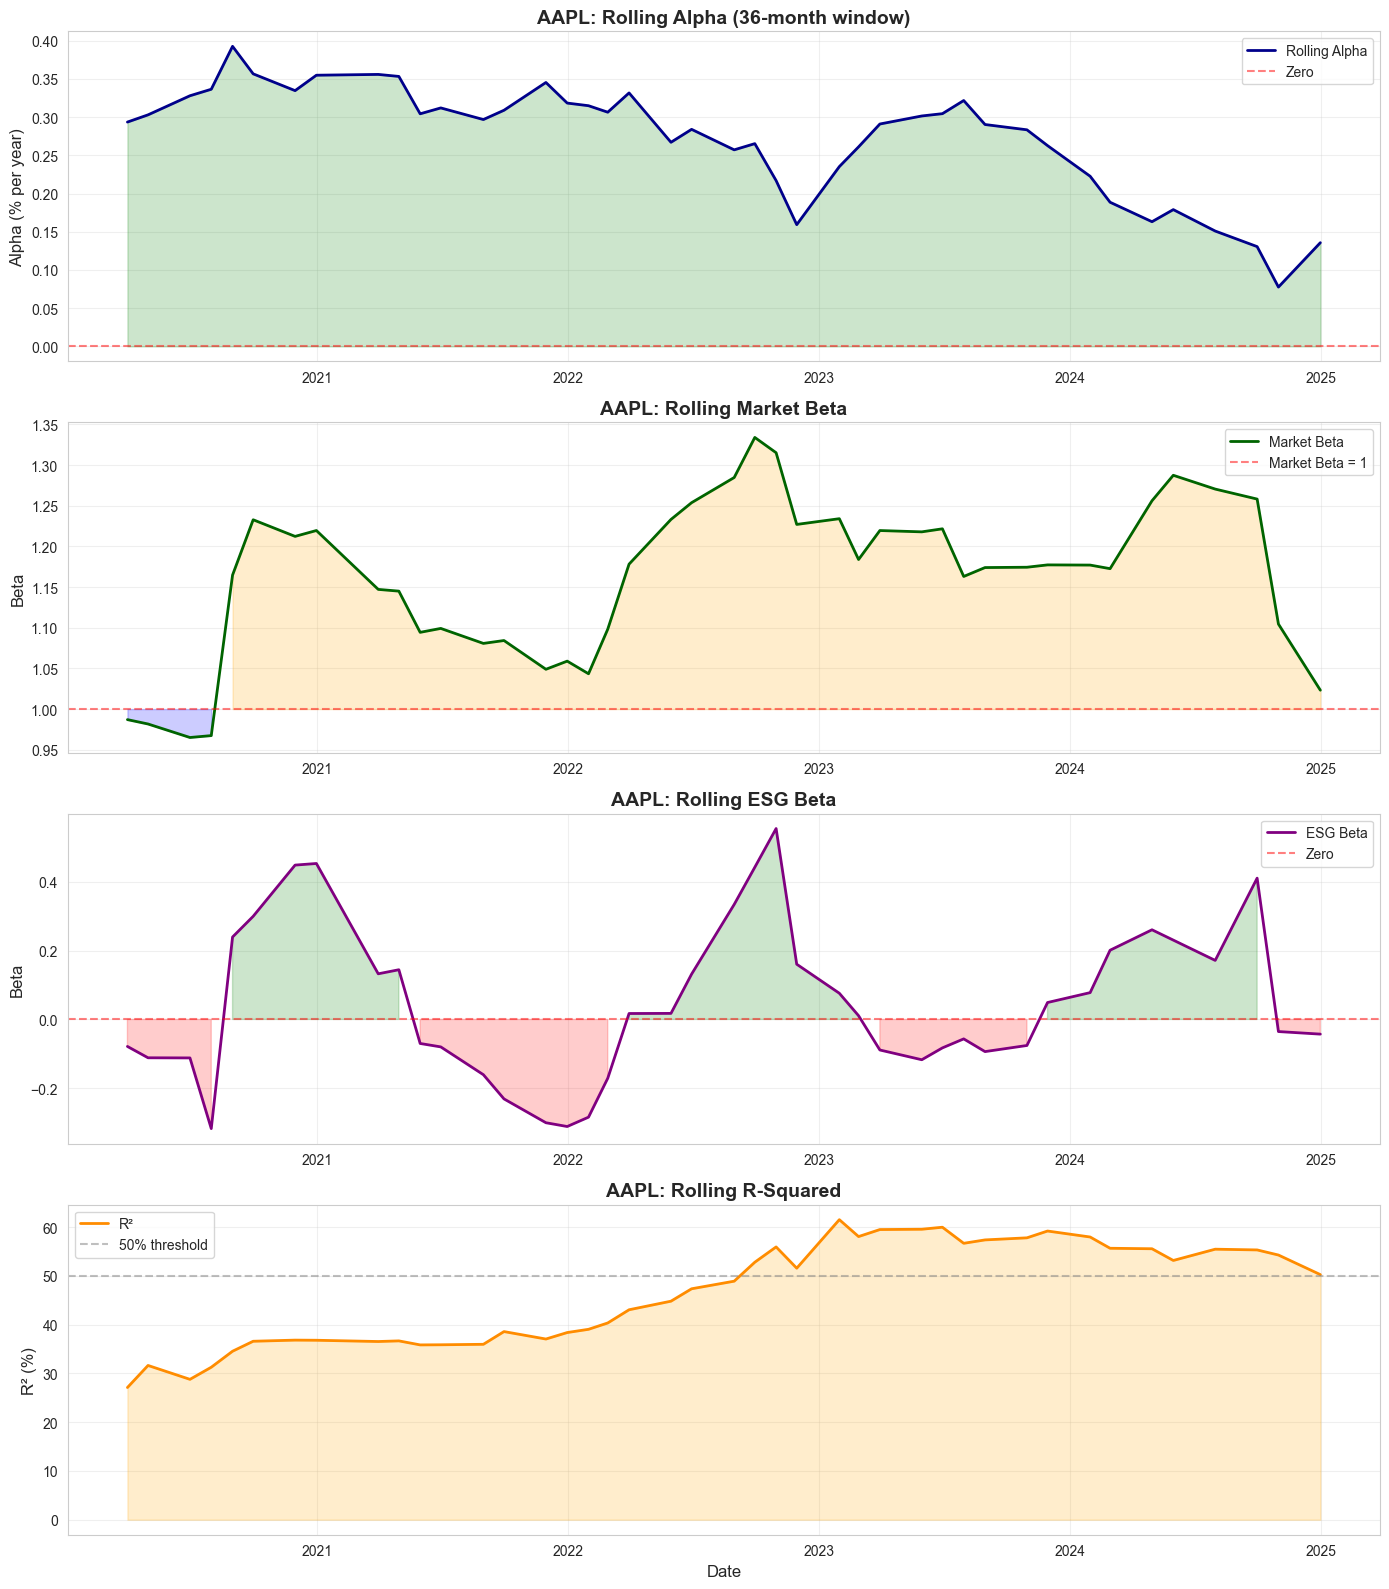


KEY INSIGHTS:
• Alpha Range: [0.08%, 0.39%] per year
• Market Beta Range: [0.97, 1.33]
• ESG Beta Range: [-0.32, 0.56]
• Average R²: 46.4%


In [9]:
# Create visualization of time-varying betas
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Alpha over time
axes[0].plot(rolling_results["date"], rolling_results["alpha"], 
             linewidth=2, label="Rolling Alpha", color='darkblue')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, label="Zero")
axes[0].fill_between(rolling_results["date"], 0, rolling_results["alpha"], 
                      where=rolling_results["alpha"] > 0, alpha=0.2, color='green')
axes[0].fill_between(rolling_results["date"], 0, rolling_results["alpha"], 
                      where=rolling_results["alpha"] < 0, alpha=0.2, color='red')
axes[0].set_title(f"AAPL: Rolling Alpha ({ROLLING_WINDOW}-month window)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Alpha (% per year)", fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Market beta over time
axes[1].plot(rolling_results["date"], rolling_results["beta_market"], 
             linewidth=2, label="Market Beta", color='darkgreen')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.5, label="Market Beta = 1")
axes[1].fill_between(rolling_results["date"], 1.0, rolling_results["beta_market"], 
                      where=rolling_results["beta_market"] > 1.0, alpha=0.2, color='orange')
axes[1].fill_between(rolling_results["date"], 1.0, rolling_results["beta_market"], 
                      where=rolling_results["beta_market"] < 1.0, alpha=0.2, color='blue')
axes[1].set_title("AAPL: Rolling Market Beta", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Beta", fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# ESG beta over time
axes[2].plot(rolling_results["date"], rolling_results["beta_esg"], 
             linewidth=2, label="ESG Beta", color='purple')
axes[2].axhline(0, color='red', linestyle='--', alpha=0.5, label="Zero")
axes[2].fill_between(rolling_results["date"], 0, rolling_results["beta_esg"], 
                      where=rolling_results["beta_esg"] > 0, alpha=0.2, color='green')
axes[2].fill_between(rolling_results["date"], 0, rolling_results["beta_esg"], 
                      where=rolling_results["beta_esg"] < 0, alpha=0.2, color='red')
axes[2].set_title("AAPL: Rolling ESG Beta", fontsize=14, fontweight='bold')
axes[2].set_ylabel("Beta", fontsize=12)
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

# R-squared over time
axes[3].plot(rolling_results["date"], rolling_results["r_squared"] * 100, 
             linewidth=2, label="R²", color='darkorange')
axes[3].axhline(50, color='gray', linestyle='--', alpha=0.5, label="50% threshold")
axes[3].fill_between(rolling_results["date"], 0, rolling_results["r_squared"] * 100, 
                      alpha=0.2, color='orange')
axes[3].set_title("AAPL: Rolling R-Squared", fontsize=14, fontweight='bold')
axes[3].set_ylabel("R² (%)", fontsize=12)
axes[3].set_xlabel("Date", fontsize=12)
axes[3].legend(loc='best')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
print(f"• Alpha Range: [{rolling_results['alpha'].min():.2f}%, {rolling_results['alpha'].max():.2f}%] per year")
print(f"• Market Beta Range: [{rolling_results['beta_market'].min():.2f}, {rolling_results['beta_market'].max():.2f}]")
print(f"• ESG Beta Range: [{rolling_results['beta_esg'].min():.2f}, {rolling_results['beta_esg'].max():.2f}]")
print(f"• Average R²: {rolling_results['r_squared'].mean() * 100:.1f}%")

## 10. Batch Processing: Multiple Stocks

Run regressions for all tickers and aggregate results for comparison.

In [10]:
# Run full-sample regression for all tickers
batch_results = []

for ticker in TICKERS:
    print(f"\nProcessing {ticker}...")
    
    try:
        # Load stock returns
        stock_df = load_stock_excess_returns(ticker, START_DATE, END_DATE)
        if stock_df is None or len(stock_df) < MIN_OBS:
            print(f"  ⚠️  Insufficient data for {ticker}")
            continue
        
        # Merge with market and ESG factors
        reg_data = stock_df.merge(market_df[["date", "market_excess"]], on="date")
        reg_data = reg_data.merge(esg_df[["date", "ESG_factor"]], on="date")
        
        # Run regression
        y = reg_data["stock_excess"]
        X = sm.add_constant(reg_data[["market_excess", "ESG_factor"]])
        model = sm.OLS(y, X).fit()
        
        # Extract results
        alpha = model.params["const"] * 12  # Annualized
        beta_market = model.params["market_excess"]
        beta_esg = model.params["ESG_factor"]
        
        # Significance stars
        def get_stars(pval):
            if pval < 0.01: return "***"
            elif pval < 0.05: return "**"
            elif pval < 0.10: return "*"
            else: return ""
        
        alpha_stars = get_stars(model.pvalues["const"])
        beta_market_stars = get_stars(model.pvalues["market_excess"])
        beta_esg_stars = get_stars(model.pvalues["ESG_factor"])
        
        batch_results.append({
            "ticker": ticker,
            "observations": int(model.nobs),
            "alpha": alpha,
            "alpha_pval": model.pvalues["const"],
            "alpha_sig": alpha_stars,
            "beta_market": beta_market,
            "beta_market_pval": model.pvalues["market_excess"],
            "beta_market_sig": beta_market_stars,
            "beta_esg": beta_esg,
            "beta_esg_pval": model.pvalues["ESG_factor"],
            "beta_esg_sig": beta_esg_stars,
            "r_squared": model.rsquared,
            "adj_r_squared": model.rsquared_adj,
            "f_statistic": model.fvalue,
            "f_pvalue": model.f_pvalue,
        })
        
        print(f"  ✓ Alpha: {alpha:6.2f}%{alpha_stars:3s} | "
              f"Market β: {beta_market:5.2f}{beta_market_stars:3s} | "
              f"ESG β: {beta_esg:5.2f}{beta_esg_stars:3s} | "
              f"R²: {model.rsquared*100:5.1f}%")
        
    except Exception as e:
        print(f"  ✗ Error processing {ticker}: {e}")
        continue

# Convert to DataFrame
batch_df = pd.DataFrame(batch_results)

print("\n" + "="*80)
print(f"Successfully processed {len(batch_df)} stocks")
print("="*80)

batch_df


Processing AAPL...
  ✓ Alpha:   0.24%*** | Market β:  1.14*** | ESG β:  0.12    | R²:  41.3%

Processing MSFT...
  ✓ Alpha:   0.14%**  | Market β:  0.99*** | ESG β:  0.54*   | R²:  50.8%

Processing GOOGL...
  ✓ Alpha:   0.06%    | Market β:  1.05*** | ESG β:  0.51    | R²:  44.4%

Processing TSLA...
  ✓ Alpha:   0.46%*   | Market β:  1.65*** | ESG β: -0.26    | R²:  17.1%

Processing JNJ...
  ✓ Alpha:   0.06%    | Market β:  1.05*** | ESG β:  0.51    | R²:  44.4%

Processing TSLA...
  ✓ Alpha:   0.46%*   | Market β:  1.65*** | ESG β: -0.26    | R²:  17.1%

Processing JNJ...
  ✓ Alpha:  -0.02%    | Market β:  0.75*** | ESG β:  0.56**  | R²:  37.6%

Processing PG...
  ✓ Alpha:   0.06%    | Market β:  0.60*** | ESG β:  0.64**  | R²:  25.9%

Successfully processed 6 stocks
  ✓ Alpha:  -0.02%    | Market β:  0.75*** | ESG β:  0.56**  | R²:  37.6%

Processing PG...
  ✓ Alpha:   0.06%    | Market β:  0.60*** | ESG β:  0.64**  | R²:  25.9%

Successfully processed 6 stocks


,ticker,observations,alpha,alpha_pval,alpha_sig,beta_market,beta_market_pval,beta_market_sig,beta_esg,beta_esg_pval,beta_esg_sig,r_squared,adj_r_squared,f_statistic,f_pvalue
0,AAPL,77,0.2432,0.0072,***,1.1440,0.0000,***,0.1205,0.7779,,0.4125,0.3967,25.9833,0.0000
1,MSFT,77,0.1424,0.0178,**,0.9893,0.0000,***,0.5448,0.0593,*,0.5082,0.4949,38.2278,0.0000
2,GOOGL,77,0.0645,0.3716,,1.0529,0.0000,***,0.5059,0.1495,,0.4438,0.4287,29.5187,0.0000
3,TSLA,77,0.4561,0.0671,*,1.6482,0.0012,***,-0.2565,0.8296,,0.1712,0.1488,7.6434,0.0010
4,JNJ,77,-0.0169,0.7687,,0.7499,0.0000,***,0.5581,0.0478,**,0.3759,0.3590,22.2841,0.0000
5,PG,77,0.0560,0.3504,,0.6017,0.0000,***,0.6442,0.0283,**,0.2592,0.2392,12.9465,0.0000


## 11. Cross-Stock Comparisons

Visualize how different stocks differ in their factor exposures.

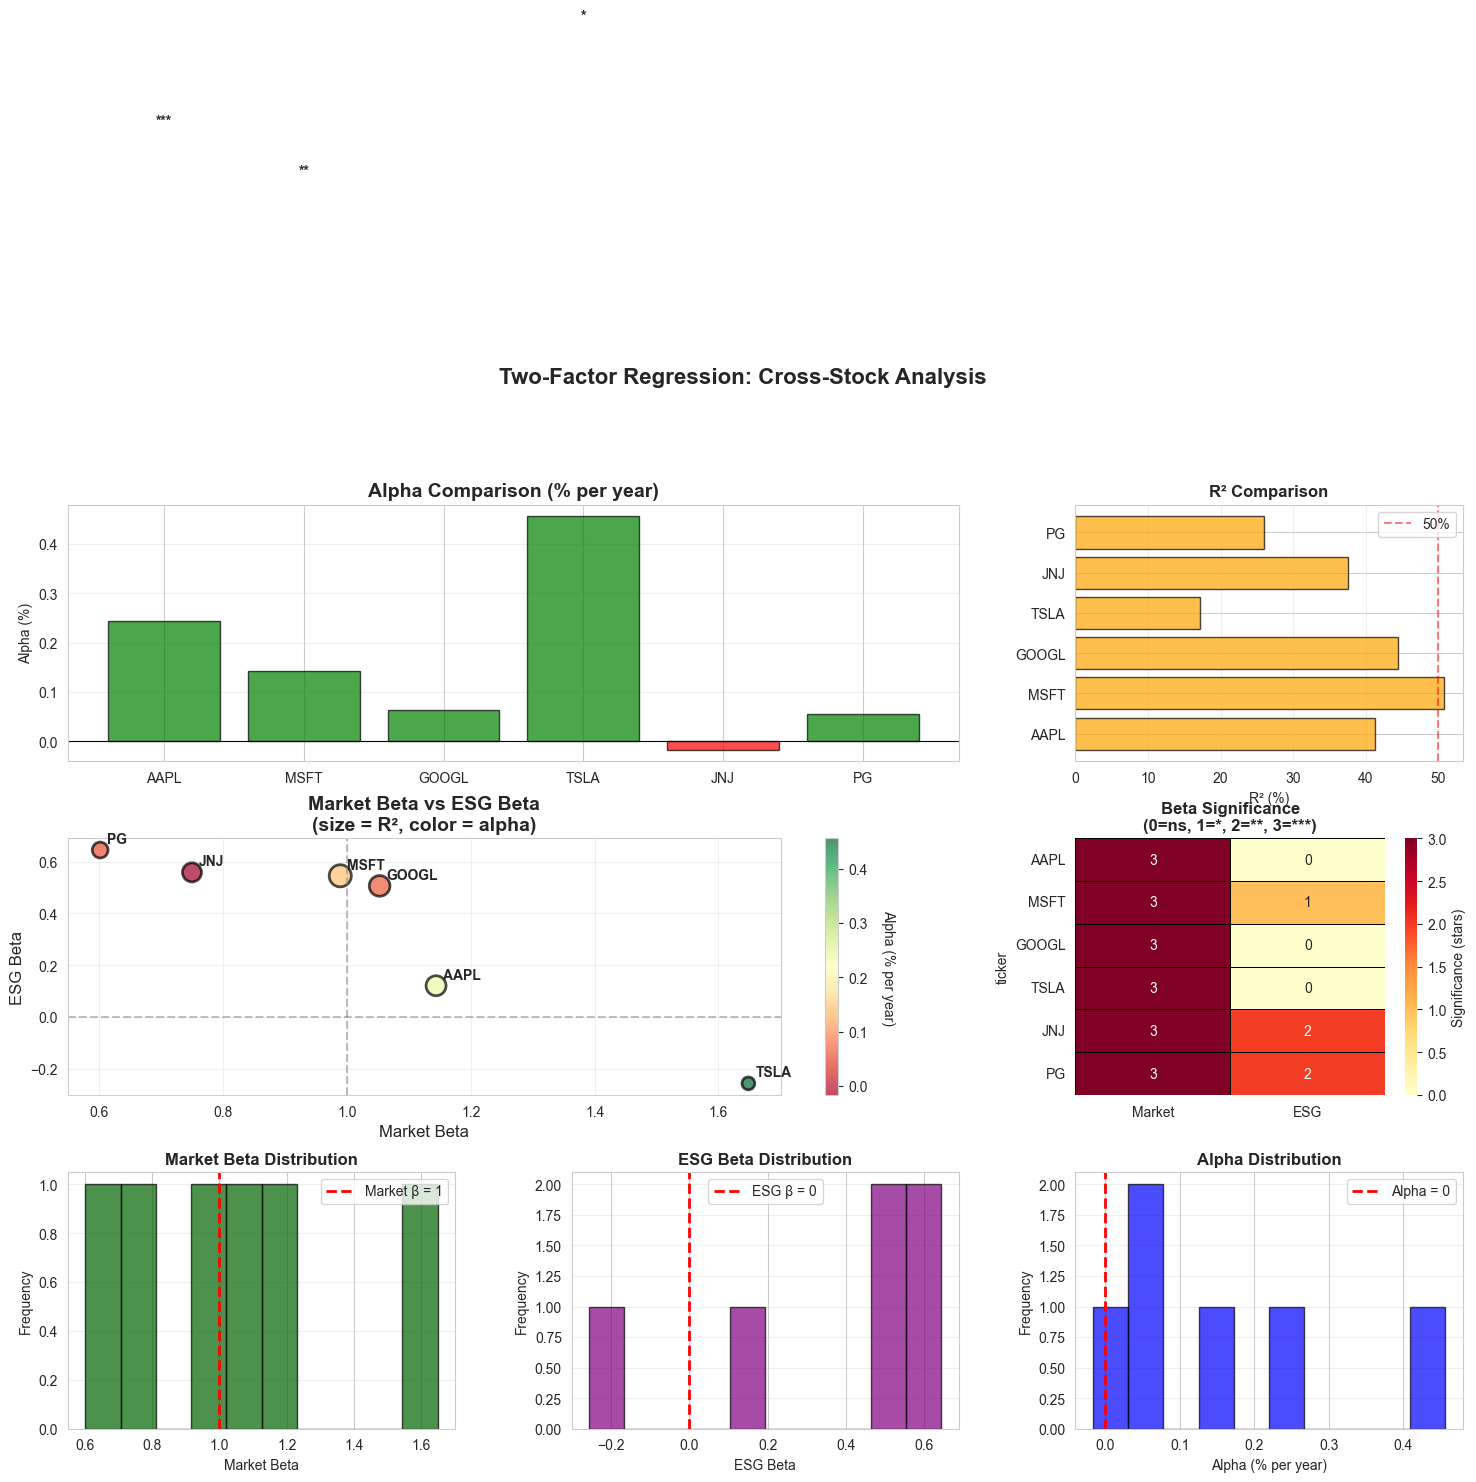

In [11]:
# Create comprehensive comparison visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Alpha comparison (bar chart)
ax1 = fig.add_subplot(gs[0, :2])
colors = ['green' if a > 0 else 'red' for a in batch_df['alpha']]
bars = ax1.bar(batch_df['ticker'], batch_df['alpha'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title("Alpha Comparison (% per year)", fontsize=14, fontweight='bold')
ax1.set_ylabel("Alpha (%)")
ax1.grid(True, alpha=0.3, axis='y')
# Add significance stars
for i, (ticker, alpha, sig) in enumerate(zip(batch_df['ticker'], batch_df['alpha'], batch_df['alpha_sig'])):
    if sig:
        ax1.text(i, alpha + 1 if alpha > 0 else alpha - 1, sig, 
                ha='center', va='bottom' if alpha > 0 else 'top', fontsize=10, fontweight='bold')

# 2. R-squared comparison (bar chart)
ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(batch_df['ticker'], batch_df['r_squared'] * 100, color='orange', alpha=0.7, edgecolor='black')
ax2.axvline(50, color='red', linestyle='--', alpha=0.5, label='50%')
ax2.set_title("R² Comparison", fontsize=12, fontweight='bold')
ax2.set_xlabel("R² (%)")
ax2.grid(True, alpha=0.3, axis='x')
ax2.legend()

# 3. Market Beta vs ESG Beta (scatter plot)
ax3 = fig.add_subplot(gs[1, :2])
scatter = ax3.scatter(batch_df['beta_market'], batch_df['beta_esg'], 
                     s=batch_df['r_squared'] * 500,  # Size by R²
                     c=batch_df['alpha'], cmap='RdYlGn', 
                     alpha=0.7, edgecolor='black', linewidth=2)
# Add ticker labels
for _, row in batch_df.iterrows():
    ax3.annotate(row['ticker'], (row['beta_market'], row['beta_esg']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(1.0, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel("Market Beta", fontsize=12)
ax3.set_ylabel("ESG Beta", fontsize=12)
ax3.set_title("Market Beta vs ESG Beta\n(size = R², color = alpha)", fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Alpha (% per year)', rotation=270, labelpad=20)

# 4. Beta significance heatmap
ax4 = fig.add_subplot(gs[1, 2])
sig_matrix = []
for _, row in batch_df.iterrows():
    sig_matrix.append([
        len(row['beta_market_sig']),  # 0-3 stars
        len(row['beta_esg_sig'])
    ])
sig_df = pd.DataFrame(sig_matrix, columns=['Market', 'ESG'], index=batch_df['ticker'])
sns.heatmap(sig_df, annot=True, cmap='YlOrRd', fmt='d', cbar_kws={'label': 'Significance (stars)'},
            ax=ax4, linewidths=0.5, linecolor='black')
ax4.set_title("Beta Significance\n(0=ns, 1=*, 2=**, 3=***)", fontsize=12, fontweight='bold')

# 5. Market Beta distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(batch_df['beta_market'], bins=10, color='darkgreen', alpha=0.7, edgecolor='black')
ax5.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Market β = 1')
ax5.set_xlabel("Market Beta")
ax5.set_ylabel("Frequency")
ax5.set_title("Market Beta Distribution", fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. ESG Beta distribution
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(batch_df['beta_esg'], bins=10, color='purple', alpha=0.7, edgecolor='black')
ax6.axvline(0, color='red', linestyle='--', linewidth=2, label='ESG β = 0')
ax6.set_xlabel("ESG Beta")
ax6.set_ylabel("Frequency")
ax6.set_title("ESG Beta Distribution", fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 7. Alpha distribution
ax7 = fig.add_subplot(gs[2, 2])
ax7.hist(batch_df['alpha'], bins=10, color='blue', alpha=0.7, edgecolor='black')
ax7.axvline(0, color='red', linestyle='--', linewidth=2, label='Alpha = 0')
ax7.set_xlabel("Alpha (% per year)")
ax7.set_ylabel("Frequency")
ax7.set_title("Alpha Distribution", fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle("Two-Factor Regression: Cross-Stock Analysis", fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 12. Statistical Significance Analysis

Analyze the distribution of p-values and significance across stocks.

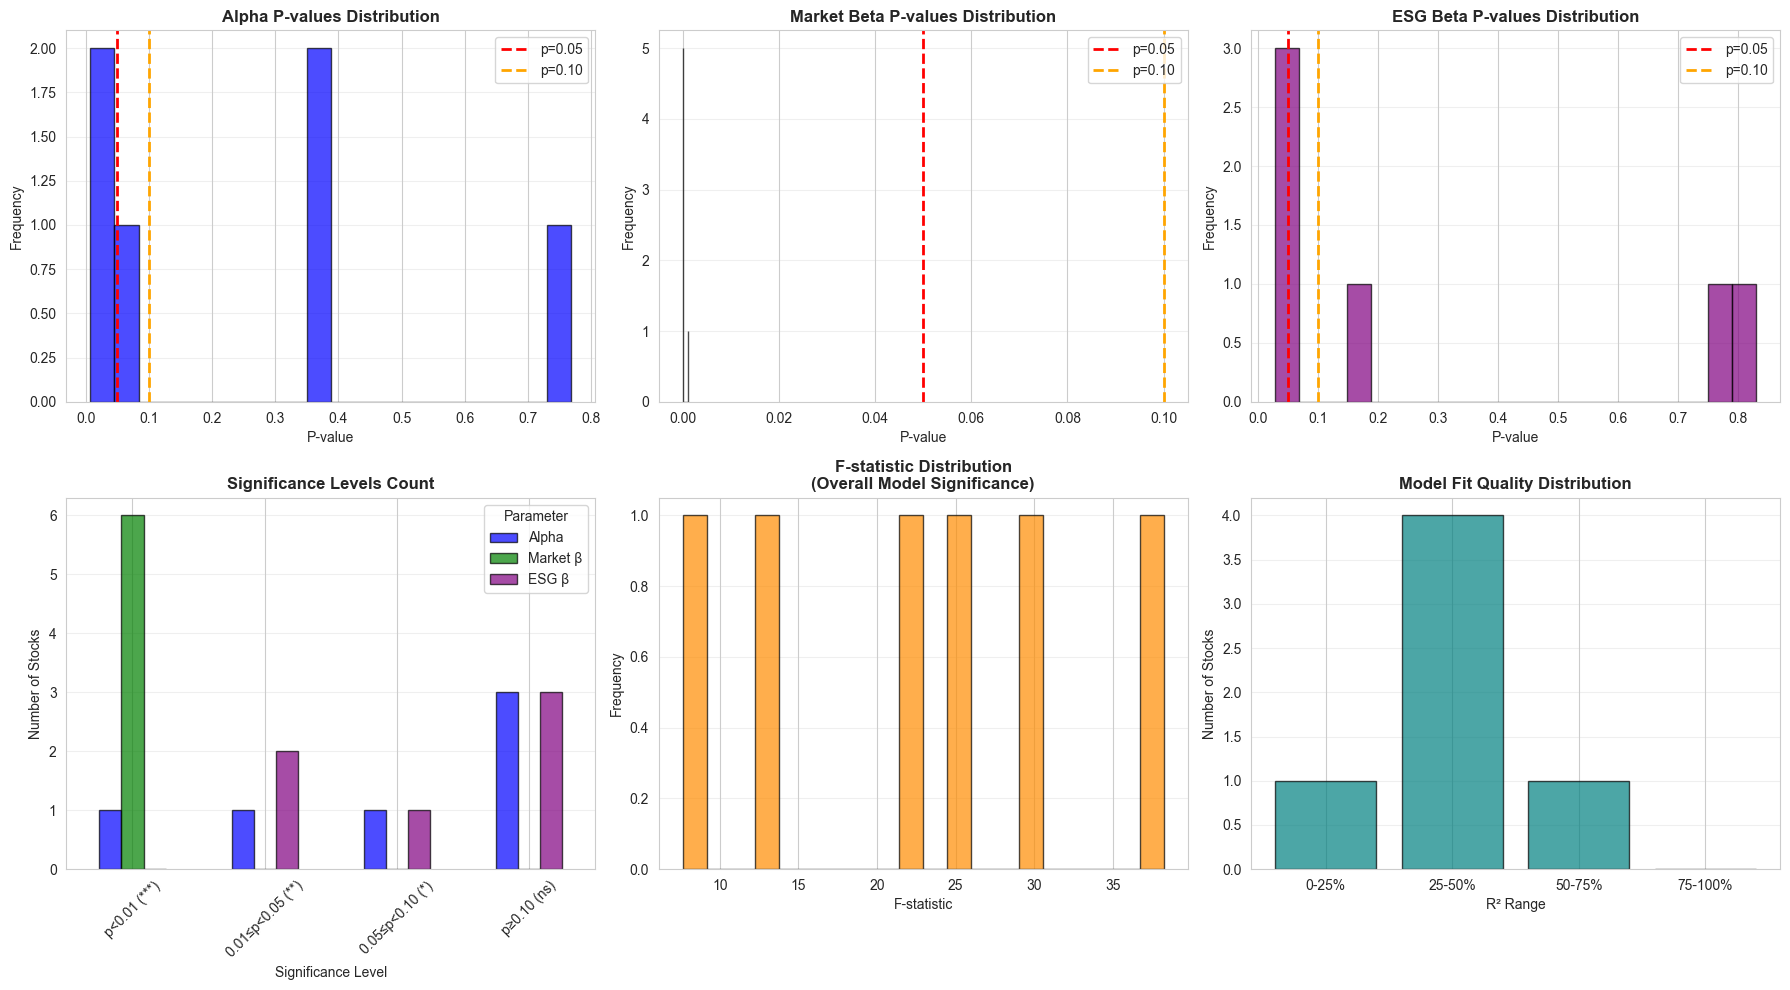


SIGNIFICANCE SUMMARY

Parameter       p<0.01     p<0.05     p<0.10     Not Sig   
-------------------------------------------------------
Alpha           1          2          3          3         
Market Beta     6          6          6          0         
ESG Beta        0          2          3          3         



In [12]:
# Statistical significance analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Alpha p-values distribution
axes[0, 0].hist(batch_df['alpha_pval'], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
axes[0, 0].axvline(0.10, color='orange', linestyle='--', linewidth=2, label='p=0.10')
axes[0, 0].set_xlabel("P-value")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Alpha P-values Distribution", fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Market beta p-values distribution
axes[0, 1].hist(batch_df['beta_market_pval'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
axes[0, 1].axvline(0.10, color='orange', linestyle='--', linewidth=2, label='p=0.10')
axes[0, 1].set_xlabel("P-value")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Market Beta P-values Distribution", fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# ESG beta p-values distribution
axes[0, 2].hist(batch_df['beta_esg_pval'], bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[0, 2].axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
axes[0, 2].axvline(0.10, color='orange', linestyle='--', linewidth=2, label='p=0.10')
axes[0, 2].set_xlabel("P-value")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].set_title("ESG Beta P-values Distribution", fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Significance counts (bar chart)
sig_counts = pd.DataFrame({
    'Alpha': [
        (batch_df['alpha_pval'] < 0.01).sum(),
        ((batch_df['alpha_pval'] >= 0.01) & (batch_df['alpha_pval'] < 0.05)).sum(),
        ((batch_df['alpha_pval'] >= 0.05) & (batch_df['alpha_pval'] < 0.10)).sum(),
        (batch_df['alpha_pval'] >= 0.10).sum(),
    ],
    'Market β': [
        (batch_df['beta_market_pval'] < 0.01).sum(),
        ((batch_df['beta_market_pval'] >= 0.01) & (batch_df['beta_market_pval'] < 0.05)).sum(),
        ((batch_df['beta_market_pval'] >= 0.05) & (batch_df['beta_market_pval'] < 0.10)).sum(),
        (batch_df['beta_market_pval'] >= 0.10).sum(),
    ],
    'ESG β': [
        (batch_df['beta_esg_pval'] < 0.01).sum(),
        ((batch_df['beta_esg_pval'] >= 0.01) & (batch_df['beta_esg_pval'] < 0.05)).sum(),
        ((batch_df['beta_esg_pval'] >= 0.05) & (batch_df['beta_esg_pval'] < 0.10)).sum(),
        (batch_df['beta_esg_pval'] >= 0.10).sum(),
    ],
}, index=['p<0.01 (***)', '0.01≤p<0.05 (**)', '0.05≤p<0.10 (*)', 'p≥0.10 (ns)'])

sig_counts.plot(kind='bar', ax=axes[1, 0], color=['blue', 'green', 'purple'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title("Significance Levels Count", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("Number of Stocks")
axes[1, 0].set_xlabel("Significance Level")
axes[1, 0].legend(title="Parameter")
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# F-statistic distribution
axes[1, 1].hist(batch_df['f_statistic'], bins=20, color='darkorange', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel("F-statistic")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("F-statistic Distribution\n(Overall Model Significance)", fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Model fit quality
model_quality = pd.DataFrame({
    'R² Range': ['0-25%', '25-50%', '50-75%', '75-100%'],
    'Count': [
        (batch_df['r_squared'] < 0.25).sum(),
        ((batch_df['r_squared'] >= 0.25) & (batch_df['r_squared'] < 0.50)).sum(),
        ((batch_df['r_squared'] >= 0.50) & (batch_df['r_squared'] < 0.75)).sum(),
        (batch_df['r_squared'] >= 0.75).sum(),
    ]
})
axes[1, 2].bar(model_quality['R² Range'], model_quality['Count'], 
               color='teal', alpha=0.7, edgecolor='black')
axes[1, 2].set_title("Model Fit Quality Distribution", fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel("Number of Stocks")
axes[1, 2].set_xlabel("R² Range")
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SIGNIFICANCE SUMMARY")
print("="*80)
print(f"\n{'Parameter':<15} {'p<0.01':<10} {'p<0.05':<10} {'p<0.10':<10} {'Not Sig':<10}")
print("-"*55)
print(f"{'Alpha':<15} {(batch_df['alpha_pval'] < 0.01).sum():<10} "
      f"{(batch_df['alpha_pval'] < 0.05).sum():<10} "
      f"{(batch_df['alpha_pval'] < 0.10).sum():<10} "
      f"{(batch_df['alpha_pval'] >= 0.10).sum():<10}")
print(f"{'Market Beta':<15} {(batch_df['beta_market_pval'] < 0.01).sum():<10} "
      f"{(batch_df['beta_market_pval'] < 0.05).sum():<10} "
      f"{(batch_df['beta_market_pval'] < 0.10).sum():<10} "
      f"{(batch_df['beta_market_pval'] >= 0.10).sum():<10}")
print(f"{'ESG Beta':<15} {(batch_df['beta_esg_pval'] < 0.01).sum():<10} "
      f"{(batch_df['beta_esg_pval'] < 0.05).sum():<10} "
      f"{(batch_df['beta_esg_pval'] < 0.10).sum():<10} "
      f"{(batch_df['beta_esg_pval'] >= 0.10).sum():<10}")
print("\n" + "="*80)